# Fuel Price Analysis Across Station Types and Regions in NSW

### Dataset Summary
The NSW FuelCheck dataset (fuel.csv) provides historical and live fuel prices across New South Wales, maintained by the NSW Government. 

I am using the "FuelCheck Price History Jan 2025" file, downloaded in February 2025, and stored as fuel.csv.

Additionally, I have a dataset of Australian postcodes (postcodes.json) with latitude and longitude details, sourced from a GitHub user Elkfox. This dataset, stored as postcodes.json, helps in mapping fuel station locations accurately.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### The dataset contains an extra column on the left starting from row 32,001 onward, which needs to be removed for consistency.

In [2]:
def clean_bad_line(bl):
    if len(bl) == 9:
        return bl[1:] 
    return bl
 
df = pd.read_csv(
    'fuel.csv', 
    on_bad_lines=clean_bad_line,
    engine='python'  
)

print('Shape:',df.shape,'\n')
print(df.info())
print('\n\n')
print(df.head())

Shape: (60151, 8) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60151 entries, 0 to 60150
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ServiceStationName  60151 non-null  object 
 1   Address             60151 non-null  object 
 2   Suburb              60151 non-null  object 
 3   Postcode            60151 non-null  int64  
 4   Brand               60151 non-null  object 
 5   FuelCode            60151 non-null  object 
 6   PriceUpdatedDate    60151 non-null  object 
 7   Price               60151 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 3.7+ MB
None



     ServiceStationName                                 Address   Suburb  \
0         Shell Croydon  418-424 LIVERPOOL RD, CROYDON NSW 2132  CROYDON   
1  Ampol Foodary Coogee  146-148 COOGEE BAY RD, COOGEE NSW 2034   COOGEE   
2  Ampol Foodary Coogee  146-148 COOGEE BAY RD, COOGEE NSW 2034   COOGEE   
3  Ampol

### Standardizing column names and filtering NSW entries

In [3]:
df.rename(columns={'ServiceStationName': 'Name'}, inplace=True)
df['Suburb'] = df['Suburb'].str.upper()

# Keep only rows with 'NSW' or 'NEW SOUTH WALES' in the Address
df = df[df["Address"].str.contains(r"\bNSW\b|\bNEW SOUTH WALES\b", case=False, na=False)]

print(f"Data after filtering NSW entries:\nShape: {df.shape}\n")
print(df.head())

Data after filtering NSW entries:
Shape: (59256, 8)

                   Name                                 Address   Suburb  \
0         Shell Croydon  418-424 LIVERPOOL RD, CROYDON NSW 2132  CROYDON   
1  Ampol Foodary Coogee  146-148 COOGEE BAY RD, COOGEE NSW 2034   COOGEE   
2  Ampol Foodary Coogee  146-148 COOGEE BAY RD, COOGEE NSW 2034   COOGEE   
3  Ampol Foodary Coogee  146-148 COOGEE BAY RD, COOGEE NSW 2034   COOGEE   
4  Ampol Foodary Coogee  146-148 COOGEE BAY RD, COOGEE NSW 2034   COOGEE   

   Postcode  Brand FuelCode     PriceUpdatedDate  Price  
0      2132  Shell      P98  2025-01-01 02:17:21  205.9  
1      2034  Ampol      P98  2025-01-01 02:18:03  211.9  
2      2034  Ampol      U91  2025-01-01 02:18:03  187.9  
3      2034  Ampol      E10  2025-01-01 02:18:03  185.9  
4      2034  Ampol      P95  2025-01-01 02:18:04  203.9  


### Loading postcodes.json data and removing unnecessary columns

In [4]:
df_postcodes = pd.read_json("postcodes.json")
df_postcodes.drop(columns=["accuracy"], inplace=True)

print(f"Postcode data loaded:\nShape: {df_postcodes.shape}\n")
print(df_postcodes.head())

Postcode data loaded:
Shape: (16875, 6)

   postcode                      place_name                    state_name  \
0       200  Australian National University  Australian Capital Territory   
1       221                          Barton  Australian Capital Territory   
2      2540                       Wreck Bay  Australian Capital Territory   
3      2540                   Hmas Creswell  Australian Capital Territory   
4      2540                      Jervis Bay  Australian Capital Territory   

  state_code  latitude  longitude  
0        ACT  -35.2777   149.1189  
1        ACT  -35.3049   149.1412  
2        ACT  -35.1627   150.6907  
3        ACT  -35.0280   150.5501  
4        ACT  -35.1333   150.7000  


### Merging fuel data with postcode data

In [5]:
df_postcodes['place_name'] = df_postcodes['place_name'].str.upper()

df_merged = df.merge(
    df_postcodes, 
    how='left', 
    left_on=['Postcode', 'Suburb'], 
    right_on=['postcode', 'place_name']
)

df_merged.rename(columns={'latitude': 'Latitude', 'longitude': 'Longitude'}, inplace=True)

# Handling missing latitude/longitude values
df_postcode_match = df_postcodes.sort_values('place_name').drop_duplicates(subset=['postcode'], keep='first')

df_merged = df_merged.merge(
    df_postcode_match, 
    left_on='Postcode', 
    right_on='postcode', 
    how='left'
)

df_merged['Latitude'] = df_merged['Latitude'].fillna(df_merged['latitude'])
df_merged['Longitude'] = df_merged['Longitude'].fillna(df_merged['longitude'])

# Drop redundant columns
df_merged.drop(columns=['postcode_x', 'place_name_x', 'state_name_x', 'state_code_x', 
                        'postcode_y', 'place_name_y', 'state_name_y', 'state_code_y', 
                        'latitude', 'longitude'], inplace=True)

df_merged.to_csv('fuel_data_cleaned.csv', index=False)
print(f"Data merged and saved.\nShape: {df_merged.shape}\n")
print(df_merged.head())

Data merged and saved.
Shape: (59256, 10)

                   Name                                 Address   Suburb  \
0         Shell Croydon  418-424 LIVERPOOL RD, CROYDON NSW 2132  CROYDON   
1  Ampol Foodary Coogee  146-148 COOGEE BAY RD, COOGEE NSW 2034   COOGEE   
2  Ampol Foodary Coogee  146-148 COOGEE BAY RD, COOGEE NSW 2034   COOGEE   
3  Ampol Foodary Coogee  146-148 COOGEE BAY RD, COOGEE NSW 2034   COOGEE   
4  Ampol Foodary Coogee  146-148 COOGEE BAY RD, COOGEE NSW 2034   COOGEE   

   Postcode  Brand FuelCode     PriceUpdatedDate  Price  Latitude  Longitude  
0      2132  Shell      P98  2025-01-01 02:17:21  205.9  -33.8833   151.1167  
1      2034  Ampol      P98  2025-01-01 02:18:03  211.9  -33.9205   151.2552  
2      2034  Ampol      U91  2025-01-01 02:18:03  187.9  -33.9205   151.2552  
3      2034  Ampol      E10  2025-01-01 02:18:03  185.9  -33.9205   151.2552  
4      2034  Ampol      P95  2025-01-01 02:18:04  203.9  -33.9205   151.2552  


### Computing daily average fuel prices per station and postcode

In [6]:
station_daily_avg = df_merged.groupby(['Name', 'FuelCode', 'Postcode', 'PriceUpdatedDate'])['Price'].mean().reset_index()
postcode_daily_avg = station_daily_avg.groupby(['Postcode', 'FuelCode'])['Price'].mean()

# Creating a MultiIndex to ensure all postcodes and fuel types are represented
all_postcodes = sorted(df_merged['Postcode'].unique())
all_fuelcodes = sorted(df_merged['FuelCode'].unique()) 
multi_index = pd.MultiIndex.from_product([all_postcodes, all_fuelcodes], names=['Postcode', 'FuelType'])

# Reindexing to fill missing postcode-fuel type combinations with a default price of 0.00
# This ensures that every postcode and fuel type is represented in the dataset, even if no price data is available for a specific combination.
postcode_daily_avg_filled = pd.DataFrame(postcode_daily_avg).reindex(multi_index, fill_value=0.00) 
postcode_daily_avg_filled['Price'] = postcode_daily_avg_filled['Price'].round(2)
df_avg_price = postcode_daily_avg_filled.rename(columns={'Price': 'AveragePrice'})

print(f"Computed daily average fuel prices.\nShape: {df_avg_price.shape}\n")
print(df_avg_price.head(24))

Computed daily average fuel prices.
Shape: (4048, 1)

                   AveragePrice
Postcode FuelType              
2007     DL              197.57
         E10             178.15
         E85               0.00
         LPG               0.00
         P95             194.69
         P98             205.15
         PDL               0.00
         U91               0.00
2008     DL                0.00
         E10               0.00
         E85               0.00
         LPG               0.00
         P95             189.70
         P98             199.70
         PDL             191.37
         U91             175.30
2011     DL              201.40
         E10             172.77
         E85               0.00
         LPG               0.00
         P95             191.98
         P98             200.98
         PDL               0.00
         U91               0.00


### Calculating price deviation from average

In [7]:
df_avg_price_reset = df_avg_price.reset_index()
df_final = df_merged.merge(df_avg_price_reset, left_on=['Postcode', 'FuelCode'], right_on=['Postcode', 'FuelType'], how='left')

df_final['PriceChangeAverage'] = ((df_final['Price'] - df_final['AveragePrice']) / df_final['AveragePrice']) * 100
df_final['PriceChangeAverage'] = df_final['PriceChangeAverage'].round(2)

df_final.drop(columns=['FuelType', 'AveragePrice'], inplace=True)

print(f"Calculated price deviations.\nShape: {df_final.shape}\n")
print(df_final.head())

Calculated price deviations.
Shape: (59256, 11)

                   Name                                 Address   Suburb  \
0         Shell Croydon  418-424 LIVERPOOL RD, CROYDON NSW 2132  CROYDON   
1  Ampol Foodary Coogee  146-148 COOGEE BAY RD, COOGEE NSW 2034   COOGEE   
2  Ampol Foodary Coogee  146-148 COOGEE BAY RD, COOGEE NSW 2034   COOGEE   
3  Ampol Foodary Coogee  146-148 COOGEE BAY RD, COOGEE NSW 2034   COOGEE   
4  Ampol Foodary Coogee  146-148 COOGEE BAY RD, COOGEE NSW 2034   COOGEE   

   Postcode  Brand FuelCode     PriceUpdatedDate  Price  Latitude  Longitude  \
0      2132  Shell      P98  2025-01-01 02:17:21  205.9  -33.8833   151.1167   
1      2034  Ampol      P98  2025-01-01 02:18:03  211.9  -33.9205   151.2552   
2      2034  Ampol      U91  2025-01-01 02:18:03  187.9  -33.9205   151.2552   
3      2034  Ampol      E10  2025-01-01 02:18:03  185.9  -33.9205   151.2552   
4      2034  Ampol      P95  2025-01-01 02:18:04  203.9  -33.9205   151.2552   

   PriceChang

### Computing price changes compared to the previous day

In [8]:
df_final = df_final.sort_values(by=['Name', 'FuelCode', 'PriceUpdatedDate'])
df_final['PriceChangePrevious'] = df_final.groupby(['Name', 'FuelCode'])['Price'].diff()
df_final['PriceChangePrevious'] = df_final['PriceChangePrevious'].fillna(0)
df_final['PriceChangePrevious'] = df_final['PriceChangePrevious'].round(2)

print(f"Shape: {df_final.shape}\n{df_final.head()}")

Shape: (59256, 12)
                    Name                               Address   Suburb  \
214    7 Express Carlton  370 Railway Parade, Carlton NSW 2216  CARLTON   
49323  7 Express Carlton  370 Railway Parade, Carlton NSW 2216  CARLTON   
1244   7 Express Carlton  370 Railway Parade, Carlton NSW 2216  CARLTON   
49315  7 Express Carlton  370 Railway Parade, Carlton NSW 2216  CARLTON   
25818  7 Express Carlton  370 Railway Parade, Carlton NSW 2216  CARLTON   

       Postcode        Brand FuelCode     PriceUpdatedDate  Price  Latitude  \
214        2216  Independent      E10  2025-01-01 09:05:45  169.9   -33.946   
49323      2216  Independent      E10  2025-01-25 08:05:36  175.9   -33.946   
1244       2216  Independent      P95  2025-01-02 09:01:31  191.9   -33.946   
49315      2216  Independent      P95  2025-01-25 07:59:26  197.9   -33.946   
25818      2216  Independent      PDL  2025-01-14 10:06:22  175.9   -33.946   

       Longitude  PriceChangeAverage  PriceChangePrevio

### Urban and Rural:

- Postcodes with a second numeral of "0" or "1" are typically in metropolitan areas of the state's capital city, while those with higher second numerals are usually in rural and regional areas.

- Within each region, postcodes are generally assigned in ascending order as one moves further from the capital city along major highways and railways. Based on this pattern, I am categorizing postcodes as urban or rural.

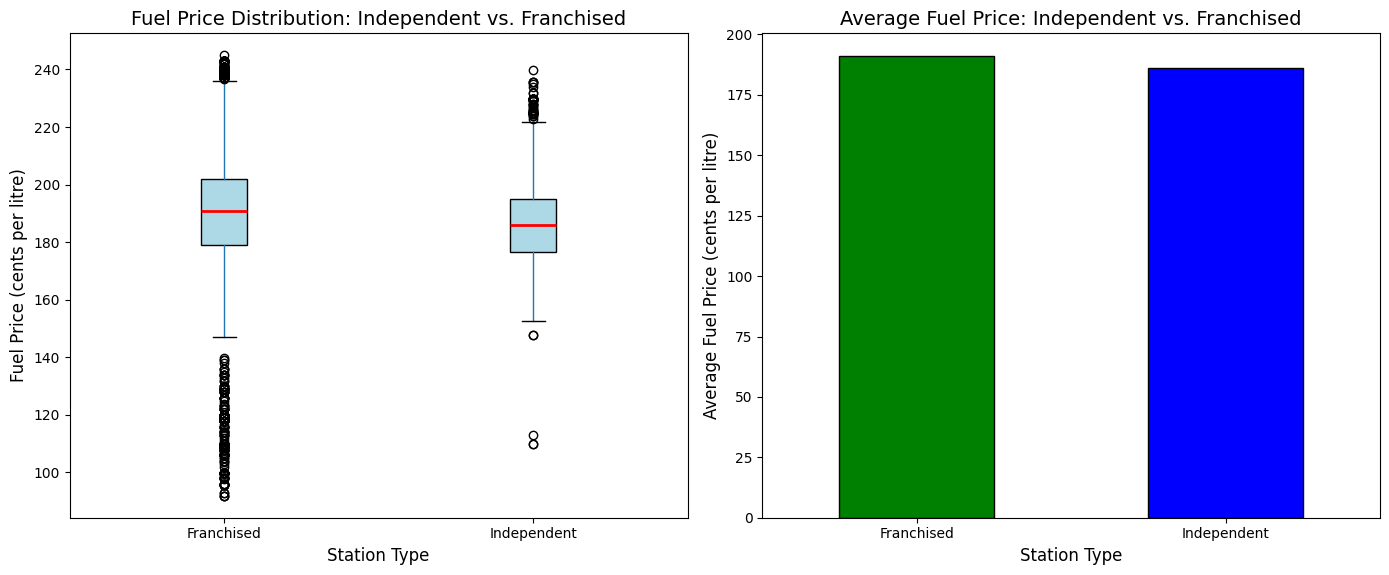

In [9]:
df_final['Station Type'] = 'Franchised'
df_final.loc[df_final['Brand'].str.contains('independent', case=False, na=False), 'Station Type'] = 'Independent'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
df_final.boxplot(column='Price', by='Station Type', grid=False, patch_artist=True, 
            boxprops=dict(facecolor="lightblue"),
            medianprops=dict(color="red", linewidth=2), ax=axes[0])
axes[0].set_xlabel('Station Type', fontsize=12)
axes[0].set_ylabel('Fuel Price (cents per litre)', fontsize=12)
axes[0].set_title('Fuel Price Distribution: Independent vs. Franchised', fontsize=14)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0) 

avg_prices = df_final.groupby('Station Type')['Price'].mean()
avg_prices.plot(kind='bar', color=['green', 'blue'], edgecolor='black', ax=axes[1])

axes[1].set_xlabel('Station Type', fontsize=12)
axes[1].set_ylabel('Average Fuel Price (cents per litre)', fontsize=12)
axes[1].set_title('Average Fuel Price: Independent vs. Franchised', fontsize=14)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0) 

plt.suptitle('') 
plt.tight_layout()
plt.show()

# Do Independent stations charge lower than Franchised stations?

## Insights from the Box Plot and Bar Plot:

### Box Plot Analysis:

- **Median**: The median for independent stations is lower than for franchised stations, indicating that, on average, independent stations offer slightly cheaper fuel prices.
- **The Box**: The box for independent stations is smaller, meaning their fuel prices don’t vary as much compared to franchised stations, which show a wider range of prices.
- **Whiskers**: The whiskers for independent stations are shorter, suggesting their prices are more consistent, whereas franchised stations have a wider range of prices.
- **Outliers**: Franchised stations have more low-price outliers, but fewer high-price outliers. Independent stations have more high-price outliers, showing a few stations with significantly higher prices, but fewer with extremely low prices.
- **Price Variability**: Franchised stations have a wider spread of prices, with more stations charging lower than median prices.
- **Higher Prices at Independents**: While independent stations generally have lower prices, they also have more stations charging significantly higher prices than median, which is not the case with franchised stations.

### Bar Plot Analysis:

The average fuel price for franchised stations is around 190.92 cents per litre, while independent stations charge an average of about 186.13 cents per litre. This confirms that independent stations generally charge slightly less.
And as we can see, independent stations tend to charge a little less on average, as shown by the lower average price in the bar plot.

### Conclusion:

While Independent stations have a slightly lower average price, they have more consistent prices, with a few stations charging higher than its median rate. Franchised stations have more price variability, with some charging lower than the median.
So, in general, it is cheaper to patron independent service stations, as they tend to have lower median prices than that of franchised stations. However, the difference is not very large and while independent stations are slightly cheaper on average, the price gap is not very significant.

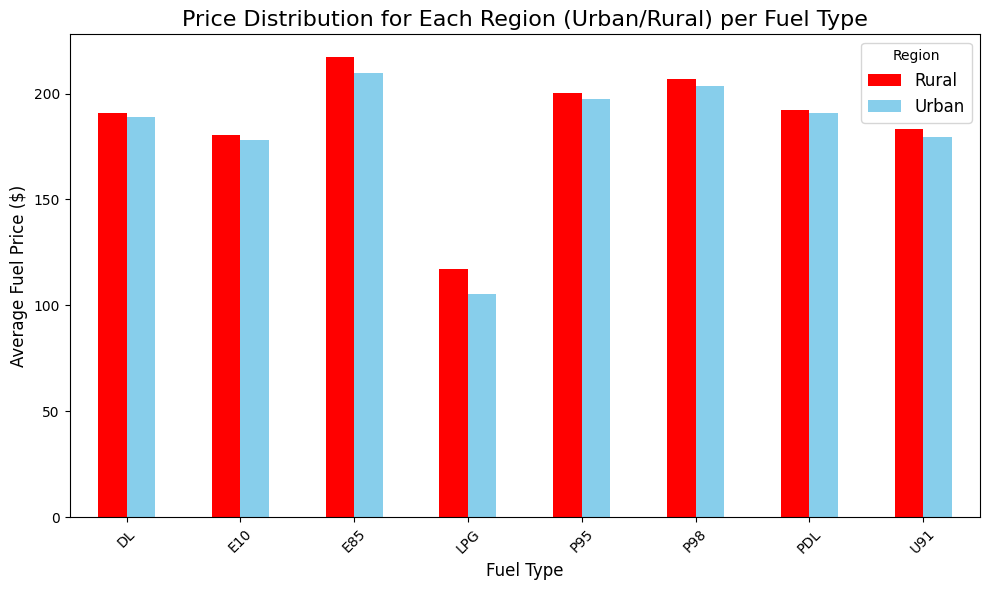

In [10]:
urban_postcodes = df_final['Postcode'].astype(str).str[1] 
df_final['Region'] = ['Urban' if x in ['0', '1'] else 'Rural' for x in urban_postcodes]
df_final_grouped = df_final.groupby(['FuelCode', 'Region'])['Price'].mean().reset_index()
df_final_pivoted = df_final_grouped.pivot(index='FuelCode', columns='Region', values='Price')
df_final_pivoted.plot(kind='bar', figsize=(10, 6), color=['red', 'skyblue'])
plt.title('Price Distribution for Each Region (Urban/Rural) per Fuel Type', fontsize=16)
plt.xlabel('Fuel Type', fontsize=12)
plt.ylabel('Average Fuel Price ($)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Region', fontsize=12)
plt.tight_layout() 
plt.show()

## Are rural consumers being charged unfairly?

### Small Price Differences:
The price of fuel in both rural and urban areas is almost the same, with only small differences. This means that people in rural areas aren’t being charged a lot more than those in cities. The differences in price are usually only a few cents per litre so it doesn’t look like rural consumers are being treated unfairly.

### Rural Areas Are a Little More Expensive:
There are a few types of fuel that are slightly more expensive in rural areas:
E10 and P95 fuels are a few cents more expensive in rural regions than in urban areas. This might be because of extra costs for delivering to these areas or fewer fuel stations in rural places.
The price difference for LPG fuel is the most noticeable. Rural areas are paying about 12 cents more per litre than urban areas. This might feel unfair to rural consumers because they might not have many options for buying LPG, so the competition is less, and the price is higher.

### Conclusion:
In conclusion, while the average fuel prices in rural and urban areas are similar, LPG seems to be a bit more expensive in rural areas. However, since these are average prices, some rural areas could have much higher fuel prices than what we see. The higher prices in certain rural areas might be due to limited supply or delivery challenges which could make them feel unfair compared to urban areas.
